In [ ]:
!pip install opencv-python
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
from tqdm import tqdm

In [ ]:
!pip install albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
print(torch.cuda.is_available())

False


In [ ]:
class CNA(nn.Module):
    def __init__(self, in_nc, out_nc, stride=1):
        super().__init__()

        self.conv = nn.Conv2d(in_nc, out_nc, 3, stride=stride, padding=1, bias=False)
        self.norm = nn.BatchNorm2d(out_nc)
        self.act = nn.GELU()

    def forward(self, x):
        out = self.conv(x)
        out = self.norm(out)
        out = self.act(out)

        return out

In [ ]:
class UnetBlock(nn.Module):
    def __init__(self, in_nc, inner_nc, out_nc, inner_block=None):
        super().__init__()

        self.conv1 = CNA(in_nc, inner_nc, stride=2)
        self.conv2 = CNA(inner_nc, inner_nc)
        self.inner_block = inner_block
        self.conv3 = CNA(inner_nc, inner_nc)
        self.conv_cat = nn.Conv2d(inner_nc+in_nc, out_nc, 3, padding=1)

    def forward(self, x):
        _,_,h,w = x.shape

        inner = self.conv1(x)
        inner = self.conv2(inner)
        #print(inner.shape)
        if self.inner_block is not None:
            inner = self.inner_block(inner)
        inner = self.conv3(inner)

        inner = F.upsample(inner, size=(h,w), mode='bilinear')
        inner = torch.cat((x, inner), axis=1)
        out = self.conv_cat(inner)

        return out

In [ ]:
class Unet(nn.Module):
    def __init__(self, in_nc=1, nc=32, out_nc=1, num_downs=6):
        super().__init__()

        self.cna1 = CNA(in_nc, nc)
        self.cna2 = CNA(nc, nc)

        unet_block = None
        for i in range(num_downs-3):
            unet_block = UnetBlock(8*nc, 8*nc, 8*nc, unet_block)
        unet_block = UnetBlock(4*nc, 8*nc, 4*nc, unet_block)
        unet_block = UnetBlock(2*nc, 4*nc, 2*nc, unet_block)
        self.unet_block = UnetBlock(nc, 2*nc, nc, unet_block)

        self.cna3 = CNA(nc, nc)

        self.conv_last = nn.Conv2d(nc, out_nc, 3, padding=1)

    def forward(self, x):
        out = self.cna1(x)
        out = self.cna2(out)
        out = self.unet_block(out)
        out = self.cna3(out)
        out = self.conv_last(out)

        return out

In [ ]:
# class Unet(nn.Module):
#     def __init__(self, nc):
#         super().__init__()
#         self.act = nn.GELU()
        
#         self.conv1 = nn.Conv2d(1, nc, 7, stride=1, padding=3)
#         self.conv2 = nn.Conv2d(nc, nc, 3, stride=1, padding=1)

#         self.conv3 = nn.Conv2d(nc, 2*nc, 3, stride=2, padding=1)
#         self.conv4 = nn.Conv2d(2*nc, 2*nc, 3, stride=1, padding=1)
        
#         self.conv5 = nn.Conv2d(3*nc, nc, 3, stride=1, padding=1)
#         self.conv6 = nn.Conv2d(nc, 1, 3, stride=1, padding=1)
    
#     def forward(self, x):
#         fea = self.conv1(x)
#         fea = self.act(fea)
#         fea = self.conv2(fea)
#         fea = self.act(fea)
#         print(fea.shape)

#         _,_,h,w = fea.shape #Находим размер входного изображения
        
#         fea_deep = self.conv3(fea)
#         print(fea.shape)
#         fea_deep = self.act(fea_deep)
#         fea_deep = self.conv4(fea_deep)
#         fea_deep = self.act(fea_deep)
#         print(fea.shape)
#         fea_deep = F.interpolate(fea_deep, size=(h,w), mode='bilinear')
#         print(fea.shape)

#         fea = torch.cat((fea, fea_deep), axis=1)
#         print(fea.shape)
#         fea = self.act(fea)
#         del fea_deep
#         fea = self.conv5(fea)
#         fea = self.act(fea)
#         fea = self.conv6(fea)

#         return fea

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self,  images_directory, masks_directory, transform=None):
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

        self.images_filenames = sorted(os.listdir(self.images_directory))

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.masks_directory, image_filename), cv2.IMREAD_COLOR)[:,:,0:1]
        image = image.astype(np.float32)/255.0
        mask = mask.astype(np.float32)/255.0
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            mask = np.transpose(mask, (2,0,1))

            #mask = torch.from_numpy(mask)
        return image, mask

In [ ]:
train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.RandomCrop(256, 256),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.Normalize(mean=(1.0, 1.0, 1.0), std=(1.0, 1.0, 1.0)),
        ToTensorV2(),
    ]
)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
train_ds_images_path = "/content/drive/MyDrive/images"
train_ds_masks_path = "/content/drive/MyDrive/masks"
test_ds_images_path = "/content/drive/MyDrive/test/images"
test_ds_masks_path = "/content/drive/MyDrive/test/masks"

In [ ]:
test_1_ds_images_path = "//content//drive//MyDrive//test_photos"

In [ ]:
print(os.path.exists(train_ds_images_path))
print(os.path.exists(train_ds_masks_path))
print(os.path.exists(test_ds_images_path))
print(os.path.exists(test_ds_masks_path))

True
True
True
True


In [ ]:
print(os.path.exists(test_1_ds_images_path))

True


In [ ]:
print(os.path.exists(train_ds_images_path))
print(os.path.exists(train_ds_masks_path))
print(os.path.exists(test_ds_images_path))
print(os.path.exists(test_ds_masks_path))

True
True
True
True


In [ ]:
ds_train = MyDataset(train_ds_images_path, train_ds_masks_path, transform=train_transform)
ds_test = MyDataset(test_ds_images_path, test_ds_masks_path, transform=train_transform)

In [ ]:
ds_1_test = MyDataset(test_1_ds_images_path, test_1_ds_images_path, transform=train_transform)

In [ ]:
ds_train[0][0].max()

tensor(1.)

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        mask = np.transpose(mask, (1,2,0))
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_augmentations(ds_test, 2)

In [ ]:
visualize_augmentations(ds_train, 0)

In [ ]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    ds_train, shuffle=True,
    batch_size=batch_size, num_workers=1, drop_last=True
)

unet_model = Unet(in_nc=3, nc=32, out_nc=1, num_downs=5)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [ ]:
count_parameters(unet_model)

8440481

In [ ]:
epochs = 6
for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(train_loader)):
        img, mask = sample
        optimizer.zero_grad()

        pred = unet_model(img)
        loss = loss_fn(pred, mask)

        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item

        optimizer.step()

    scheduler.step()
    #pbar.set_description(f'loss: {loss_item:.5f}\tlr: {scheduler.get_last_lr}')
    print(f'{loss_val/len(train_loader)}\t lr: {scheduler.get_last_lr()}')

  0%|          | 0/70 [00:00<?, ?it/s]/tmp/ipython-input-2011664096.py:21: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  inner = F.upsample(inner, size=(h,w), mode='bilinear')
100%|██████████| 70/70 [11:26<00:00,  9.81s/it]


0.2078623984541212	 lr: [0.0009000000000000001]


100%|██████████| 70/70 [10:03<00:00,  8.62s/it]


0.07088540132556642	 lr: [0.0008100000000000001]


100%|██████████| 70/70 [10:11<00:00,  8.74s/it]


0.04423919054014342	 lr: [0.000729]


100%|██████████| 70/70 [10:04<00:00,  8.64s/it]


0.04335902338581426	 lr: [0.0006561000000000001]


100%|██████████| 70/70 [10:03<00:00,  8.62s/it]


0.03668098452367953	 lr: [0.00059049]


100%|██████████| 70/70 [10:15<00:00,  8.79s/it]

0.030586693036769117	 lr: [0.000531441]


In [ ]:
img = ds_1_test[2][0].unsqueeze(0)
pred = unet_model(img)
pred = F.sigmoid(pred.detach()).numpy()[0].transpose(1,2,0)

/tmp/ipython-input-2011664096.py:21: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  inner = F.upsample(inner, size=(h,w), mode='bilinear')


In [ ]:
img = ds_test[2][0].unsqueeze(0)
pred = unet_model(img)
pred = F.sigmoid(pred.detach()).numpy()[0].transpose(1,2,0)

NameError: name 'ds_test' is not defined

In [ ]:
img_np = img.detach().numpy()[0].transpose(1,2,0)
plt.imshow(img_np)

NameError: name 'img' is not defined

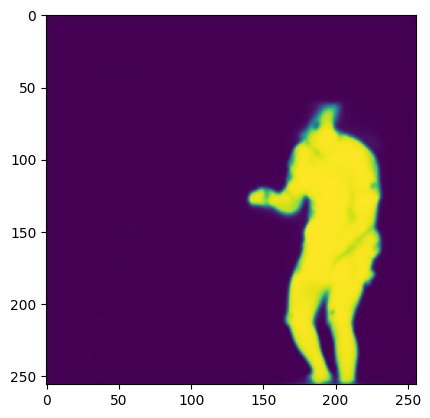

In [ ]:
plt.imshow(pred)